In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
from scipy.signal import decimate

import emd

from neurodsp.utils.norm import normalize_sig
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_branching, sim_asine_oscillation, sim_autoregressive
from timescales.fit import fit_psd, convert_knee_val
from timescales.decompose import CAD, CADGroup, AMD, ar_psd

In [2]:
# Global plot settings
SMALL_SIZE = 12
MEDIUM_SIZE = 18
LARGE_SIZE = 24

plt.rc('lines', linewidth=2)

plt.rc('font', size=SMALL_SIZE, family='sans-serif')
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=LARGE_SIZE)

plt.rc('ytick.major', size=5)
plt.rc('ytick.minor', size=2.5)
plt.rc('xtick.major', size=5)
plt.rc('xtick.minor', size=2.5)

# Autoregressive Decomposition
This notebook uses a modified version of "canonical autoregressive decomposition" (CAD) decribed in (Nagesha & Kay, 1994). CAD involves modeling sinusoids separately from AR coefficients. The modification include here adds a parameter allowing non-sinusoidality in the oscillatory term.

The second half of this notebook introduces an iterative process to automatically estimate the periodic model.

#### Aperiodic: AR(p) Model
$$A_{n} = \sum_{k=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

#### Periodic: Non-Sinusoidal Oscillatory Model

$$w_{i} = e^{j \phi_{i}} e^{j 2\pi f_{i} n}$$

$$z_{i} = w_{i} \cdot e^{j c_{i} w+{i}}$$

$$P_{n} = \sum_{i=1}^{s}z_{i}$$

#### Full Model

$$x_{n} = \sum_{i=1}^{s}z_{i} + \sum_{i=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

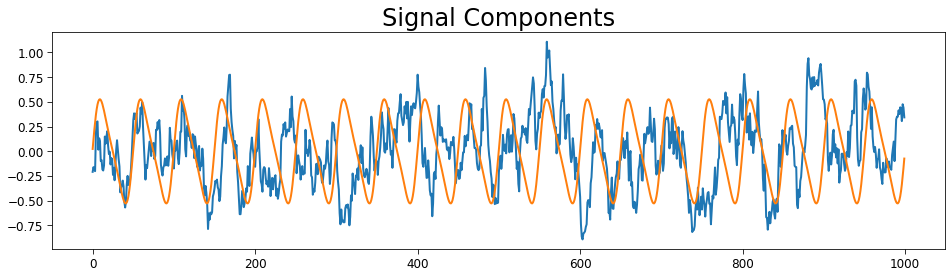

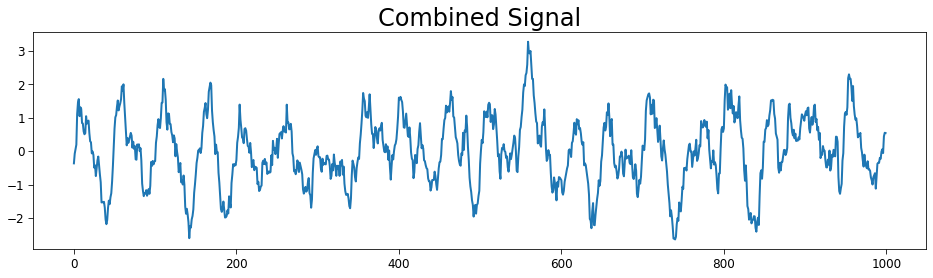

In [3]:
# Simulate
np.random.seed(0)

n_seconds = 1
fs = 1000
tau = convert_knee_val(10)
xs = np.arange(fs)

lfp = sim_branching(n_seconds, fs, tau, 100)
osc = sim_asine_oscillation(xs, fs, 20, .25, -.49, 1)

osc_var = .5
lfp = normalize_sig(lfp, 0, (1-osc_var)) 
osc = normalize_sig(osc, 0, (osc_var)) 

sig = lfp + osc

plt.figure(0, figsize=(16, 4))
plt.title('Signal Components')
plt.plot(lfp/2)
plt.plot(osc/2)

plt.figure(1, figsize=(16, 4))
plt.title('Combined Signal')
plt.plot(sig);

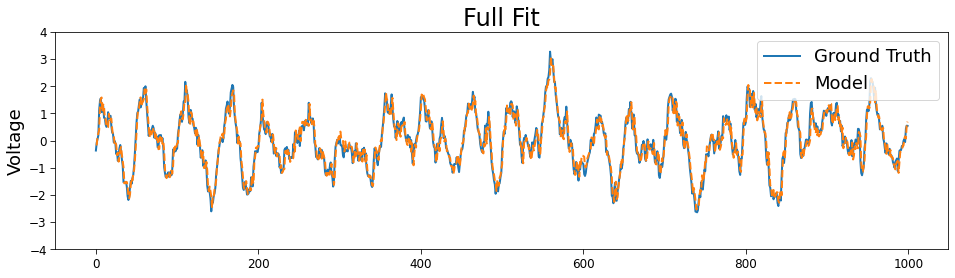

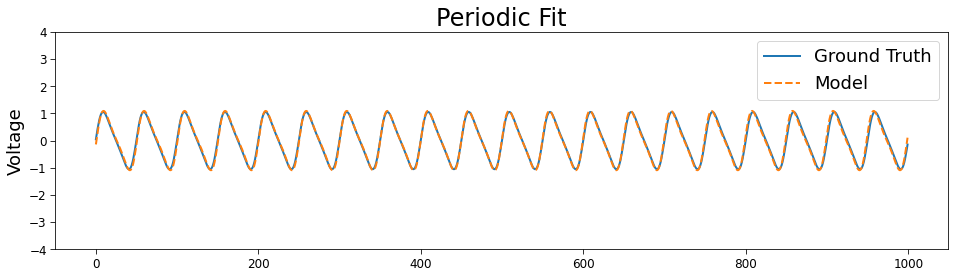

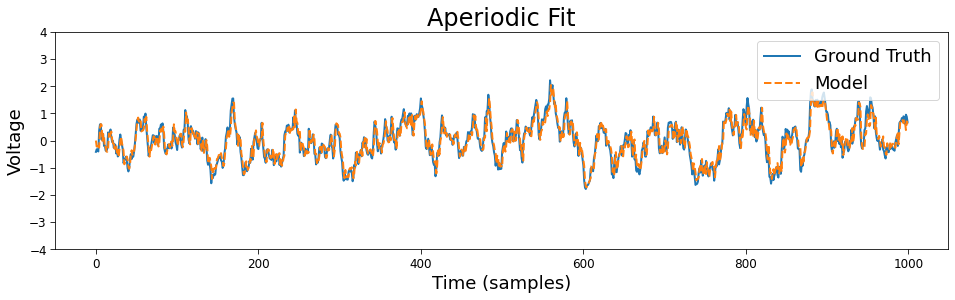

In [4]:
# Fit
osc_order = 1
ar_order = 2

cad = CAD(sig, fs, osc_order, ar_order)
cad.fit()

# Plot Results
plt.figure(0, figsize=(16, 4))
plt.title('Full Fit')
plt.plot(sig, label='Ground Truth')
plt.plot(cad.full_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.ylabel('Voltage')
plt.legend(loc='upper right');

plt.figure(1, figsize=(16, 4))
plt.title('Periodic Fit')
plt.plot(osc, label='Ground Truth')
plt.plot(cad.osc_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.ylabel('Voltage')
plt.legend(loc='upper right');

plt.figure(2, figsize=(16, 4))
plt.title('Aperiodic Fit')
plt.plot(lfp, label='Ground Truth')
plt.plot(cad.ar_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.ylabel('Voltage')
plt.xlabel('Time (samples)')
plt.legend(loc='upper right');

### Comparison to EMD

Compared to EMD, CAD is able to isolated the simulated periodic signal more accurately than EMD. Iterative EMD results are limited due to mode mixing, a problem itEMD is suppose to minimize.

Next, non-sinusoidal CAD is implemented using iterations stepping through a set of frequencies, tentatively named asymmetrical mode decomposition (AMD). This accounts for more complex non-sinusoidal interactions when isolating the periodic signal.

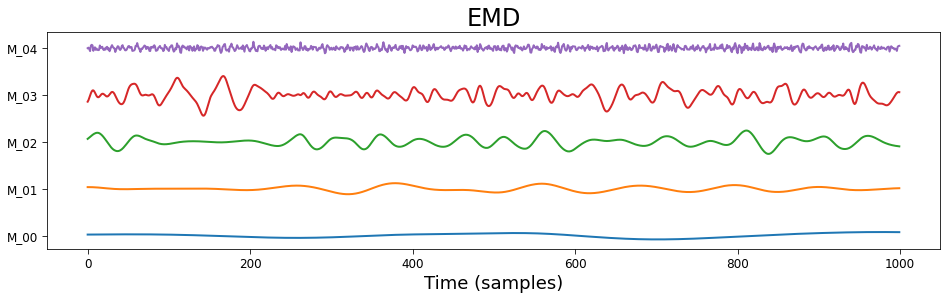

In [5]:
n_comps = 5
modes = emd.sift.iterated_mask_sift(sig, max_imfs=n_comps).T[::-1]

plt.figure(0, figsize=(16, 4))
plt.title('EMD')
j = 0
for m in modes:
    plt.plot(m+j)
    j+=5
    
plt.yticks([i*5 for i in range(n_comps)],
           labels=['M_' + str(i).zfill(2) for i in range(n_comps)]);
plt.xlabel('Time (samples)');

# Asymmetrical Mode Decomposition

Complex waveform shapes may be fit using an iterative process in which asymmetrical waves are fit to a signal in ascending (or descending) frequency order. This method extends on the non-sinusoidal model above and allows periodic and aperiodic components to be separated in the time domain, and timescale to be more accurately quantified using AR-PSD.

This process involves optimizing the oscillatory term in the CAD equation using a set of asine oscillators.

1. Define a frequency range to step through (i.e. np.arange(100))
2. For each frequency in the range: 
   <br> a. optimize the best non-sinusoidal wave that fits the signal
   <br> b. subtract the wave from the signal and continue
   
Once the modes are defined. They may be combined in various ways, using either frequency or amplitude definitions, to estimate the periodic signal.

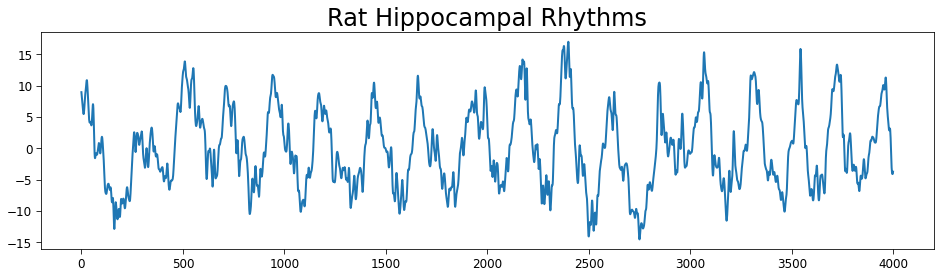

In [6]:
# Load data
file_path_dat = "/home/rph/Projects/bycycle/sim_nbs/crcns/hc2/ec013.527/ec013.527.dat"
num_channels = 31
fs = 20000

with open(file_path_dat, mode='rb') as file: 
    file_content = file.read()
    
sig = np.frombuffer(file_content, dtype=np.short)
sig = np.reshape(sig, (-1, num_channels)).T

sig = sig[20] / 100

# Slice and downsample
sig_down = decimate(sig, 10)
fs = fs/10
sig_down = filter_signal(sig_down, fs, 'lowpass', 200, remove_edges=False)

# Plot
start = 9000
end = start+4000
sig = sig_down[start:end]
sig -= sig.mean()

plt.figure(1, figsize=(16, 4))
plt.plot(sig)
plt.title('Rat Hippocampal Rhythms');

In [7]:
# Fit AMD
freqs = np.linspace(0, 100, 201)

bounds = [
    [-.25, -1, 0],
    [.25,   1, 10]
]

amd = AMD(sig, fs)
amd.fit(freqs, bounds=bounds)

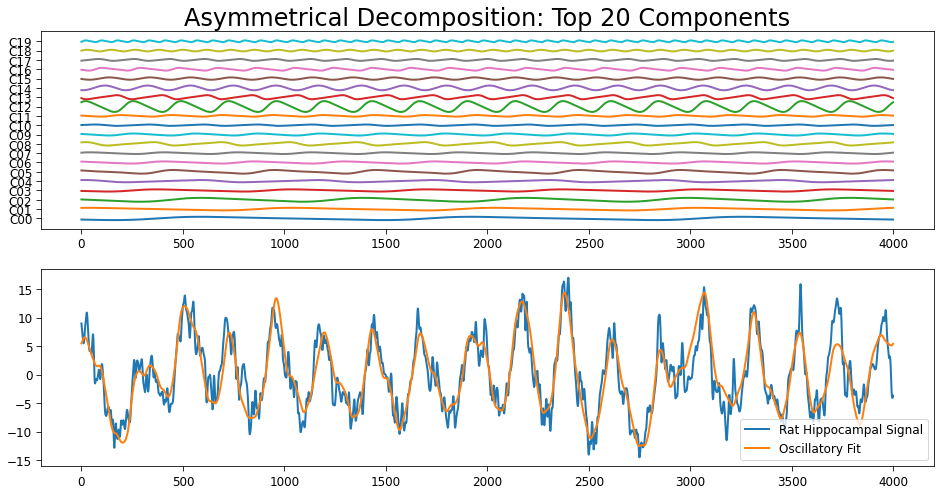

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))

n_comps = 20
j = 0
for i in np.sort(np.argsort(np.var(amd.sig_pe, axis=1))[::-1][:n_comps]):
    axes[0].plot(amd.sig_pe[i]+j)
    j+= 10
    
axes[0].set_yticks([i*10 for i in range(n_comps)], labels=['C' + str(i).zfill(2) for i in range(n_comps)])
axes[0].set_title('Asymmetrical Decomposition: Top 20 Components')


# Plot
sig_pe = amd.sig_pe[
    np.argsort(amd.sig_pe.var(axis=1))[::-1][:n_comps]
].sum(axis=0)

axes[1].plot(sig, label='Rat Hippocampal Signal')
axes[1].plot(sig_pe, label='Oscillatory Fit')
axes[1].legend(fontsize=12);
plt.savefig('asym_decomp.png', facecolor='w')

### Comparison to EMD

AMD is much slower than EMD, but allows for many modes than EMD. In AMD, each frequency is assigned one mode. AMD modes associated with an oscillatory band are combined to estimate the periodic component of the signal. This typically

In [9]:
# Bin AMD modes
order = 8

fooof_init = {'max_n_peaks':0}

inds = np.array([0, 2, 10, 20, 100, 200])
sig_amd_bin = np.zeros((len(inds)-1, len(sig)))
                       
l_inds, u_inds = inds[:-1], inds[1:]

for i, (l, u) in enumerate(zip(l_inds, u_inds)):
    sig_amd_bin[i] = amd.sig_pe[l:u].sum(axis=0)

sig_pe_amd = sig_amd_bin[2]
sig_ap_amd = sig-sig_pe_amd

# EMD for comparison
modes = emd.sift.iterated_mask_sift(sig, max_imfs=5).T[::-1]

# Get arrays and knees for plotting
sig_pe_amd = sig_amd_bin[2]
sig_ap_amd = sig-sig_pe_amd

sig_pe_emd = modes[2]
sig_ap_emd = sig-sig_pe_emd

f_ar_sig, p_ar_sig = ar_psd(sig, fs, order, f_range=(0, 200))
f_ar_emd_ap, p_ar_emd_ap= ar_psd(sig_ap_emd, fs, order, f_range=(0, 200))
f_ar_amd_ap, p_ar_amd_ap = ar_psd(sig_ap_amd, fs, order, f_range=(0, 200))

_, k_sig, _ = fit_psd(f_ar_sig, p_ar_sig, (0, 200), fooof_init=fooof_init, knee_bounds=(0, 200))
_, k_amd, _ = fit_psd(f_ar_amd_ap, p_ar_amd_ap, (0, 200), fooof_init=fooof_init, knee_bounds=(0, 200))
_, k_emd, _ = fit_psd(f_ar_emd_ap, p_ar_emd_ap, (0, 200), fooof_init=fooof_init, knee_bounds=(0, 200))

r_sq_amd = np.corrcoef(sig, sig_pe_amd)[0][1]
r_sq_emd = np.corrcoef(sig, sig_pe_emd)[0][1]

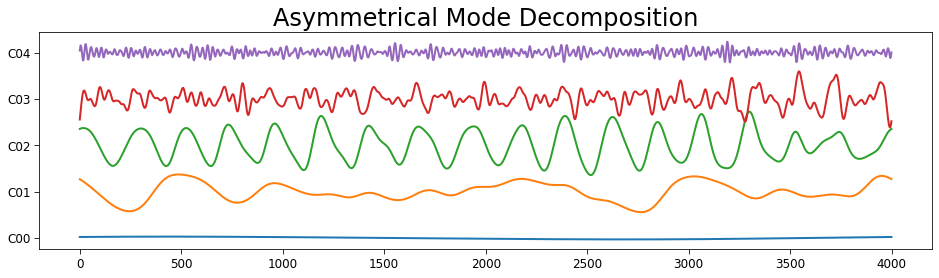

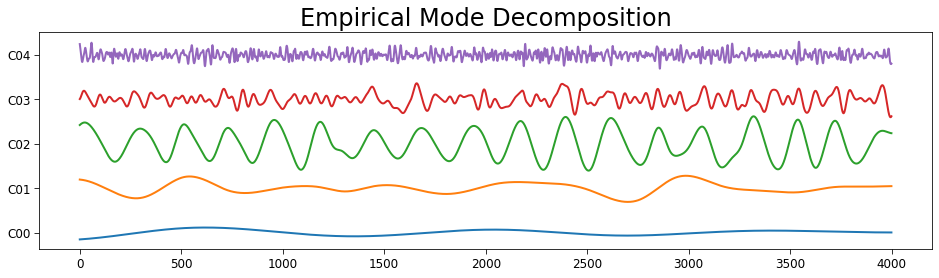

In [10]:
# Plot comparison
# AMD
plt.figure(0, figsize=(16, 4))
plt.title('Asymmetrical Mode Decomposition')
j = 0
for m in sig_amd_bin:
    plt.plot(m+j)
    j+=15
plt.yticks([i*15 for i in range(5)], labels=['C' + str(i).zfill(2) for i in range(5)])

# EMD
plt.figure(1, figsize=(16, 4))
plt.title('Empirical Mode Decomposition')
j = 0
for m in modes:
    plt.plot(m+j)
    j+=15
plt.yticks([i*15 for i in range(5)], labels=['C' + str(i).zfill(2) for i in range(5)]);

<Figure size 1152x576 with 0 Axes>

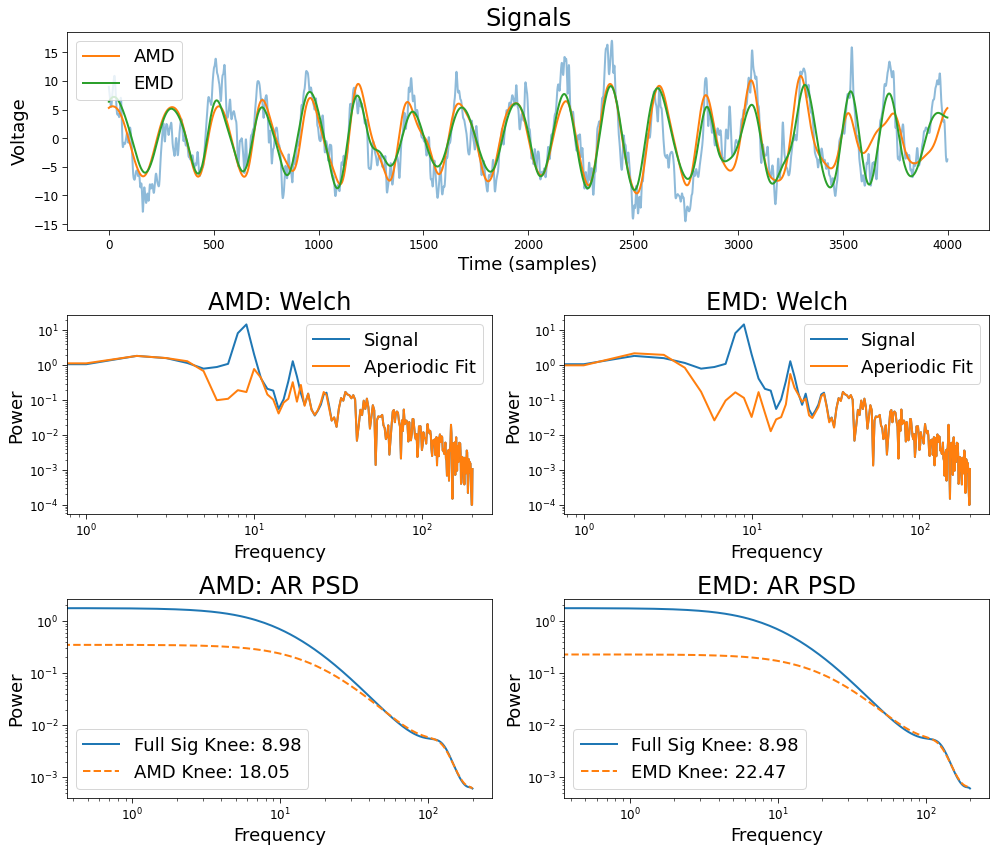

In [11]:
# Plot spec
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(3, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :1])
ax2 = fig.add_subplot(gs[1, 1:])
ax3 = fig.add_subplot(gs[2, :1])
ax4 = fig.add_subplot(gs[2, 1:])

# Plot AMD spectra
order = 8
plt.figure(0, figsize=(16, 8))

f, p = compute_spectrum(sig, fs, f_range=(0, 200))
ax1.loglog(f, p, label='Signal')

f, p = compute_spectrum(sig_ap_amd, fs, f_range=(0, 200))
ax1.loglog(f, p, label='Aperiodic Fit')

ax1.set_title('AMD: Welch')
ax1.legend()

ax3.set_title('AMD: AR PSD')
f, p = compute_spectrum(sig, fs, f_range=(0, 200))

ax3.loglog(f_ar_sig, p_ar_sig, label=f'Full Sig Knee: {k_sig.round(2)}')
ax3.loglog(f_ar_amd_ap, p_ar_amd_ap, ls='--', label=f'AMD Knee: {k_amd.round(2)}')
ax3.legend()

# Plot EMD Spectra
plt.figure(1, figsize=(6, 4))

sig_pe_emd = modes[2] 
sig_ap_emd = sig-sig_pe_emd

f, p = compute_spectrum(sig, fs, f_range=(0, 200))
ax2.loglog(f, p, label='Signal')

f, p = compute_spectrum(sig_ap_emd, fs, f_range=(0, 200))
ax2.loglog(f, p, label='Aperiodic Fit')

ax2.set_title('EMD: Welch')
ax2.legend()

ax4.set_title('EMD: AR PSD')
ax4.loglog(f_ar_sig, p_ar_sig, label=f'Full Sig Knee: {k_sig.round(2)}')
ax4.loglog(f_ar_emd_ap, p_ar_emd_ap, ls='--', label=f'EMD Knee: {k_emd.round(2)}')
ax4.legend()

# Plot signals
ax0.plot(sig, alpha=.5)
ax0.plot(sig_pe_amd, label=f'AMD')
ax0.plot(sig_pe_emd, label=f'EMD')
ax0.set_title('Signals')
ax0.legend()

# Labels
ax0.set_xlabel('Time (samples)')
ax0.set_ylabel('Voltage')
for _ax in [ax1, ax2, ax3, ax4]:
    _ax.set_ylabel('Power')
    _ax.set_xlabel('Frequency')

plt.tight_layout();

#plt.savefig('comparison.png', facecolor='w');